In [1]:
import numpy as np
import scipy 
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from tqdm.notebook import tqdm
from util.fft import * 
import scipy.io as io
from tools import * 
import pydicom as dcm
from pathlib import Path
import pickle
from glob import glob
import os

In [2]:
# plt.figure(figsize = (24,18))
# plt.imshow(stitch(np.concatenate([e1_H, e1_L, e2_H, e2_L],-1),12), cmap ="gray")
# plt.show()

In [3]:
filePath = "../lib/resource/data/T2mapping/spoil30"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
dirs = sorted(dirs)
file0 = dcm.read_file(dirs[0]) 
f = file0.pixel_array
[height, width] = f.shape
N = len(dirs)
del file0
del f

images = np.zeros([height,width,N])
for index,f in enumerate (dirs):
    image = dcm.read_file(f).pixel_array
    images[:,:,index] = image
e1_H = np.zeros([height,width,int(N/2)])
e1_L = np.zeros([height,width,int(N/2)])
e1_H = images[:,:,0:int(N/2)]
e1_L = images[:,:,int(N/2):] 
del images

filePath = "../lib/resource/data/T2mapping/spoil50"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
dirs = sorted(dirs)
images = np.zeros([height,width,N])
for index,f in enumerate (dirs):
    image = dcm.read_file(f).pixel_array
    images[:,:,index] = image
e2_H = np.zeros([height,width,int(N/2)])
e2_L = np.zeros([height,width,int(N/2)])
e2_H = images[:,:,0:int(N/2)]
e2_L = images[:,:,int(N/2):] 
del images

In [4]:
filePath = "../lib/resource/data/T2mapping/spoil30"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
dirs = np.sort(dirs)
file1 = dcm.read_file(dirs[0]) 
Glarea1 = 30*1e2

TR1 = file1.RepetitionTime*1e-3
TE1 = file1.EchoTime*1e-3
tau1 = 4.8e-3
alpha1 = file1.FlipAngle
G1 = Glarea1 /(tau1*1e6)*100
print(tau1, Glarea1, G1, TR1, TE1)

0.0048 3000.0 62.5 0.0225 0.00631


In [5]:
filePath = "../lib/resource/data/T2mapping/spoil50"
data = Path(filePath)
dirs = list(data.glob('**/*.IMA'))
dirs = np.sort(dirs)
file2 = dcm.read_file(dirs[0]) 
Glarea2 = 50*1e2

TR2 = file2.RepetitionTime*1e-3
TE2 = file2.EchoTime*1e-3
tau2 = 4.8e-3
alpha2 = file2.FlipAngle
G2 = Glarea2 /(tau2*1e6)*100
print(tau2, Glarea2, G2, TR2, TE2)

0.0048 5000.0 104.16666666666667 0.0225 0.00631


In [6]:
TR = TR1 
TE = TE1 
Tg = tau1
GhArea = Glarea2
GlArea = Glarea1
Alpha_deg = alpha1
Nstates = 6
e1_H = e1_H
e1_L = e1_L
e2_H = e2_H
e2_L = e2_L
print(TR, TE, Tg, GhArea, GlArea, Alpha_deg)

0.0225 0.00631 0.0048 5000.0 3000.0 13


In [7]:
def DESS2dFit(TR,TE,Tg,GhArea,GlArea, Alpha_deg,Nstates,e1_H,e2_H,e1_L,e2_L):
    ny, nx, ns = e1_H.shape
    adcFitBieri = np.zeros(e1_H.shape)
    t2Fit2D = np.zeros(e1_H.shape)
    adcFit2D = np.zeros(e1_H.shape)
    for s in tqdm(range(ns)):
        adcFitBieri[...,s],t2Fit2D[...,s],adcFit2D[...,s] = DESS2dFit_img(TR,TE,Tg,GhArea,GlArea, Alpha_deg,Nstates,e1_H[...,s],e2_H[...,s],e1_L[...,s],e2_L[...,s])
    
    return adcFitBieri,t2Fit2D,adcFit2D

In [8]:
adcFitBieri,t2Fit2D,adcFit2D = DESS2dFit(TR,TE,Tg,GhArea,GlArea, Alpha_deg,Nstates,e1_H,e2_H,e1_L,e2_L)

  0%|          | 0/120 [00:00<?, ?it/s]

/Users/huozimu/Desktop/pymri_recon/qDess_ADC/tools.py:226: RuntimeWarning: invalid value encountered in true_divide
  bMeasured = (e2_H*e1_L)/(e2_L*e1_H)
/Users/huozimu/Desktop/pymri_recon/qDess_ADC/tools.py:227: RuntimeWarning: invalid value encountered in true_divide
  r1Measured = np.abs(e2_H/e2_L)
/Users/huozimu/Desktop/pymri_recon/qDess_ADC/tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  r2Measured = np.abs(e2_L/e1_L)


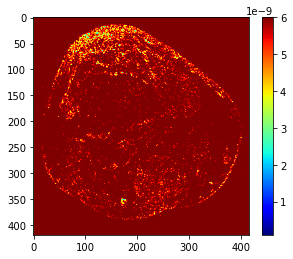

In [11]:
showc(adcFit2D[...,40])